In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import rasterio
from rasterio.transform import from_origin

In [13]:


dir_base_list = [
    # "data/AHI_H08-STAR-L3C-v2.70_CROP_lon_111_116_lat_-24.5_-19.5_time_2022-03-01T00_00_00_2022-05-01T00_00_00",
    # "data/H09-AHI-L3C-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2023-03-01T00_00_00_2023-05-01T00_00_00",
    # "data/H09-AHI-L3C-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2024-03-01T00_00_00_2024-05-01T00_00_00",
    # "data/H09-AHI-L3C-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2025-03-01T00_00_00_2025-05-01T00_00_00",
    "data/AHI_H08-STAR-L2P-v2.70_CROP_lon_111_116_lat_-24.5_-19.5_time_2022-03-01T00_00_00_2022-05-01T00_00_00",
    "data/H09-AHI-L2P-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2023-03-01T00_00_00_2023-05-01T00_00_00",
    "data/H09-AHI-L2P-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2024-03-01T00_00_00_2024-05-01T00_00_00",
    "data/H09-AHI-L2P-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2025-03-01T00_00_00_2025-05-01T00_00_00",
]

# lonlims = (111, 116)
# latlims = (-24.5, -19.5)    

lonlims = (112, 115)
latlims = (-23.5, -20.5)

# load ds for each base
ds_list = []
for dir_base in dir_base_list:
    file_merge_proc = f"{dir_base}/merge_proc.nc"
    ds = xr.open_dataset(file_merge_proc)

    if "L3C" in dir_base:
        ds = ds.sel(lon=slice(*lonlims), lat=slice(latlims[1], latlims[0]))
    # convert sst k to cel
    ds['sea_surface_temperature'] = ds['sea_surface_temperature'] - 273.15

    ds['sea_surface_temperature_dx_abs'] = abs(ds['sea_surface_temperature_dx'])
    ds['sea_surface_temperature_dy_abs'] = abs(ds['sea_surface_temperature_dy'])
    ds_list.append(ds)

In [17]:
# fig,ax = plt.subplots(1,2,figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# time = np.datetime64('2022-03-05T00:00:00')
# vmin = -1e-4
# vmax = 1e-4
# var = "sea_surface_temperature_dy"
# cmap = cmocean.cm.balance
# ds_list[0][var].sel(time=time).plot(x='lon', y='lat', ax=ax[0],vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=cmap)
# ax[0].set_ylim(latlims)
# ax[0].set_xlim(lonlims)

# ds_list[1][var].sel(time=time).plot(x='lon', y='lat', ax=ax[1],vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=cmap)
# ax[1].set_ylim(latlims)
# ax[1].set_xlim(lonlims)

# # add coast line and land 
# for axi in ax:
#     axi.coastlines()
#     axi.add_feature(cfeature.LAND, facecolor='gray', zorder=10)
#     # axi.set_xticks(np.arange(np.floor(lonlims[0]), np.ceil(lonlims[1])+1, 1), crs=ccrs.PlateCarree())
#     # axi.set_yticks(np.arange(np.floor(latlims[0]), np.ceil(latlims[1])+1, 1), crs=ccrs.PlateCarree())
#     # axi.gridlines(draw_labels=True)

In [ ]:

def data_to_tif(X,Y,data,file):
    # X, Y are your projected coordinates (2D meshgrid)
    # assume uniform spacing (true for GOES/Himawari grids)
    dx = (X[0,1] - X[0,0])   # pixel size in X (meters)
    dy = (Y[1,0] - Y[0,0])   # pixel size in Y (meters)

    # upper-left corner
    x0 = X[0,0]
    y0 = Y[0,0]

    transform = from_origin(x0, y0, dx, -dy)

    crs_proj = {
        "proj": "geos",
        "h": 35785863.0,
        "lon_0": 140.7,
        "sweep": "y",
        "datum": "WGS84"
    }

    with rasterio.open(
        file,
        "w",
        driver="GTiff",
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs=crs_proj,
        transform=transform,
    ) as dst:
        dst.write(data, 1)




In [25]:
import xarray as xr
import rioxarray

# Load GeoTIFF into xarray
da = rioxarray.open_rasterio("goes_native_geos.tif")

# Drop rasterio-specific dimension names
da = da.squeeze("band", drop=True)
da


<xarray.DataArray (y: 201, x: 213)> Size: 171kB
[42813 values with dtype=float32]
Coordinates:
  * x            (x) float64 2kB -2.87e+06 -2.868e+06 ... -2.448e+06 -2.446e+06
  * y            (y) float64 2kB -2.09e+06 -2.092e+06 ... -2.488e+06 -2.49e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [26]:
def plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims,vmin,vmax):

    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': proj}, sharex=True,sharey=True)
    for i, ds in enumerate(ds_list):        
        ax = axs[i // 2, i % 2]
        if var == "gradient":
            data = np.sqrt(ds['sea_surface_temperature_dx']**2 + ds['sea_surface_temperature_dy']**2)
        else:
            data = ds[var]
        if type == "mean":
            data = data.mean(dim="time")
        elif type == "std":
            data = data.std(dim="time")
        elif type == "var":
            data = data.var(dim="time")
        else:
            raise ValueError("Invalid type")
        data.plot(ax=ax, transform=proj, x='lon', y='lat', cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax)
        
        t_start = pd.Timestamp(ds.time.values[0]).strftime('%Y/%m')
        t_end = pd.Timestamp(ds.time.values[-1]).strftime('%Y/%m')
        ax.set_title(f"{t_start} - {t_end}")
        
        ax.add_feature(cfeature.LAND, facecolor='gray',zorder=10)
        ax.coastlines()
        
        ax.set_xticks(np.arange(np.floor(lonlims[0]), np.ceil(lonlims[1])+1, 1), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(np.floor(latlims[0]), np.ceil(latlims[1])+1, 1), crs=ccrs.PlateCarree())
        
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_extent([lonlims[0], lonlims[1], latlims[0], latlims[1]], crs=proj)

    fig.suptitle(f"{var} {type}", fontsize=18)
    # plt.tight_layout()
    # plt.show()
    
    return fig, axs
    



In [37]:
def save_tiff_properties(ds_list, var, type):

    for i, ds in enumerate(ds_list):        
        if var == "gradient":
            data = np.sqrt(ds['sea_surface_temperature_dx']**2 + ds['sea_surface_temperature_dy']**2)
        else:
            data = ds[var]
            
        if type == "mean":
            data = data.mean(dim="time")
        elif type == "std":
            data = data.std(dim="time")
        elif type == "var":
            data = data.var(dim="time")
        else:
            raise ValueError("Invalid type")
        
        data = data.values
        X = ds['X'].values
        Y = ds['Y'].values
        
        t_start = pd.Timestamp(ds.time.values[0]).strftime('%Y%m')
        t_end = pd.Timestamp(ds.time.values[-1]).strftime('%Y%m')
        t_str = f"{t_start}-{t_end}"
        
        data_to_tif(X, Y, data, f"gis_files/{var}_{type}_{t_str}.tif")
        
        



In [38]:
save_fig = False
to_tif = True

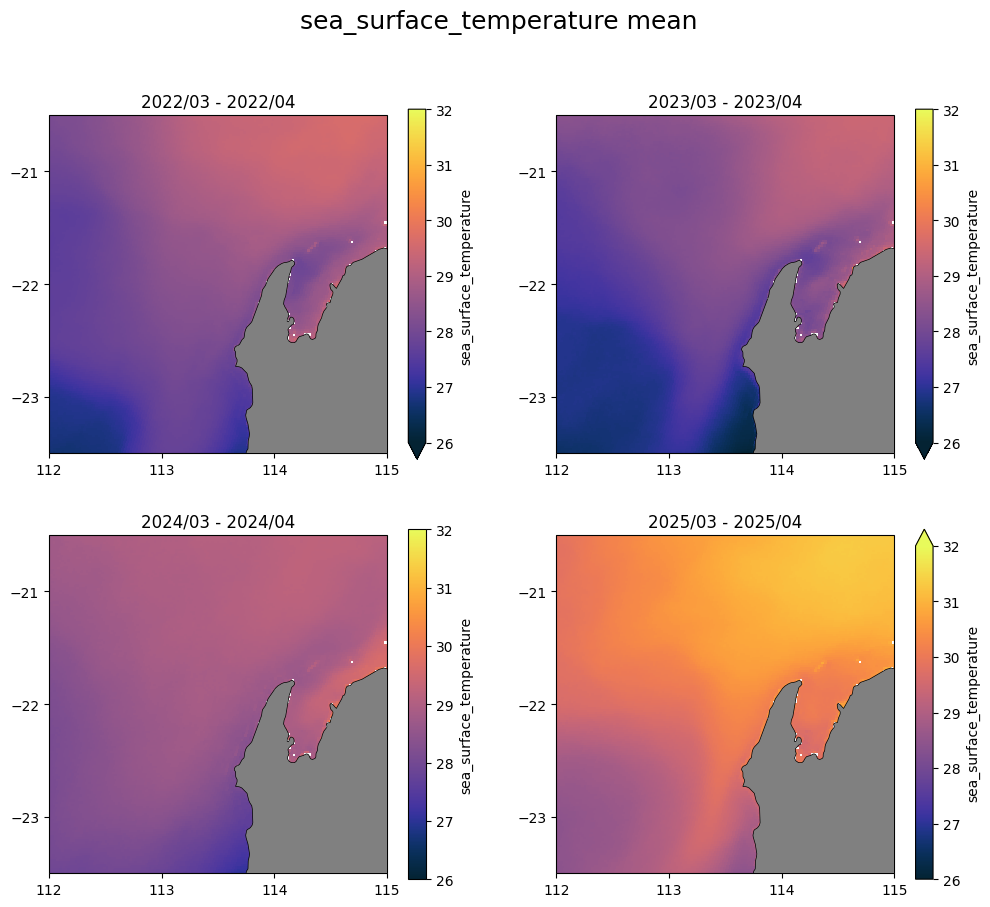

In [39]:
var = "sea_surface_temperature"
type = "mean"
cmap = cmocean.cm.thermal
vmin = 26
vmax = 32
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degr

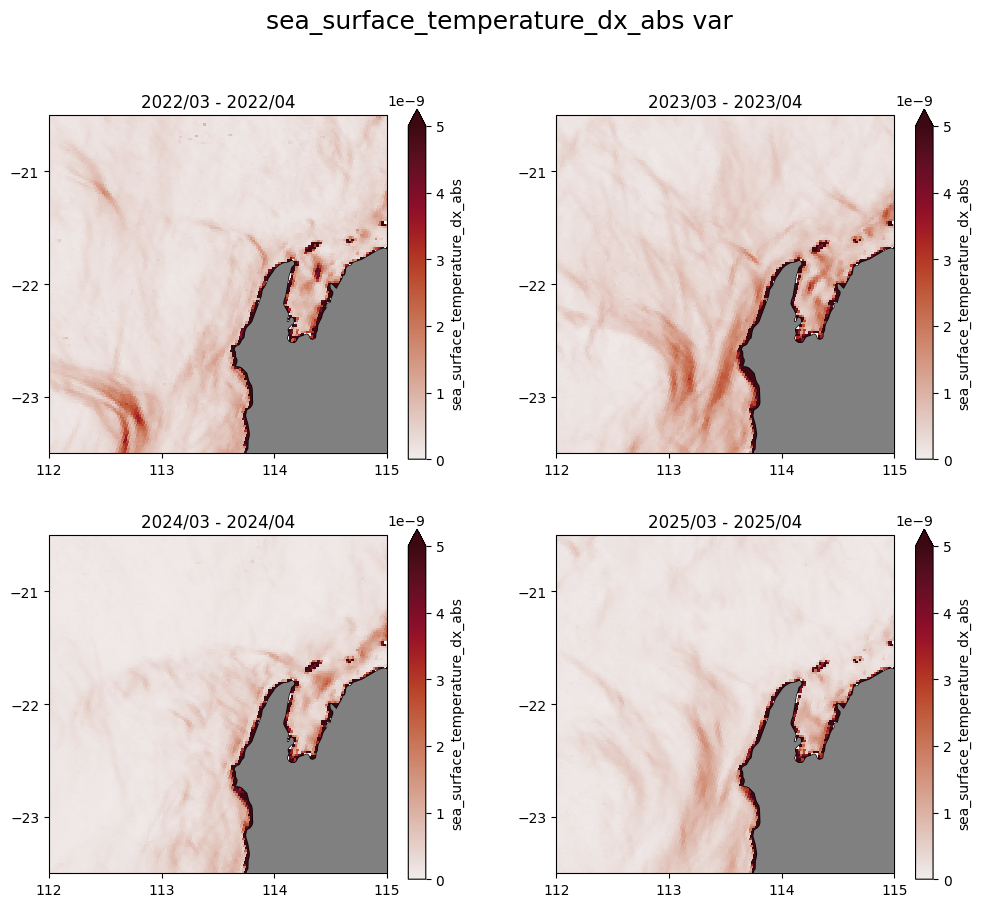

In [40]:
var ="sea_surface_temperature_dx_abs"
type = "var"
cmap = cmocean.cm.amp
vmin = 0
vmax = 5e-9
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degr

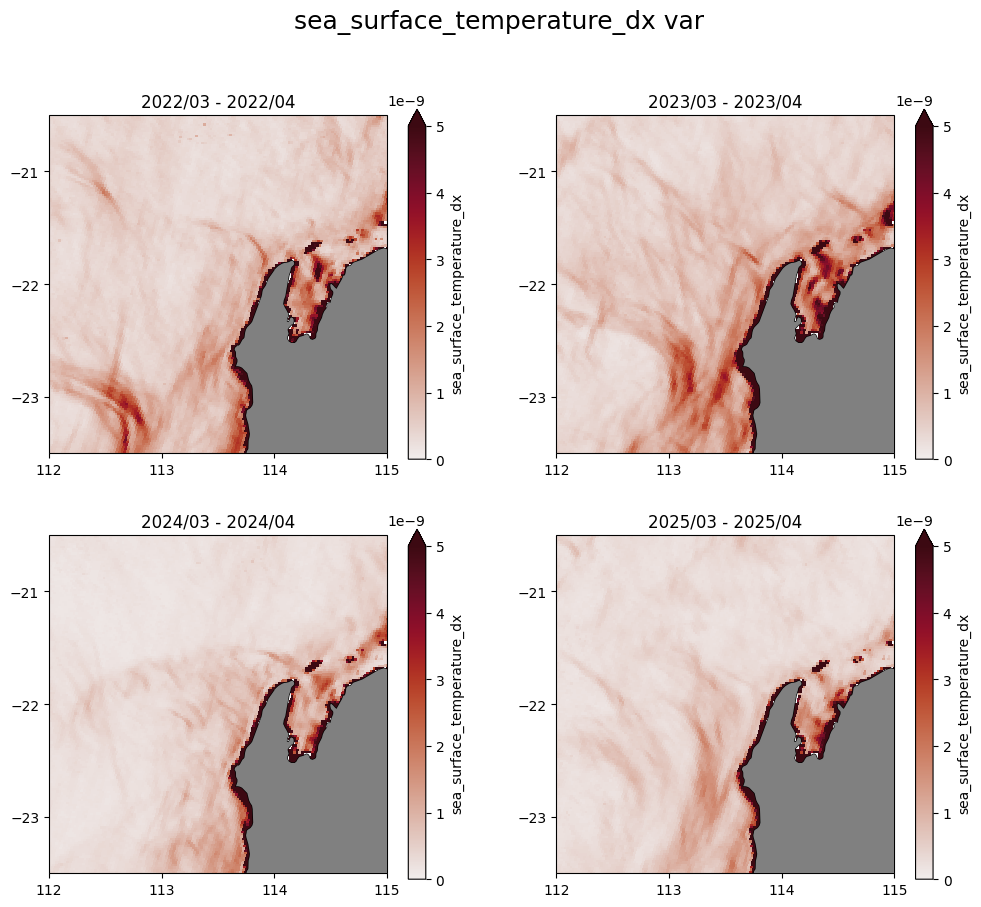

In [41]:
var ="sea_surface_temperature_dx"
type = "var"
cmap = cmocean.cm.amp
vmin = 0
vmax = 5e-9
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degr

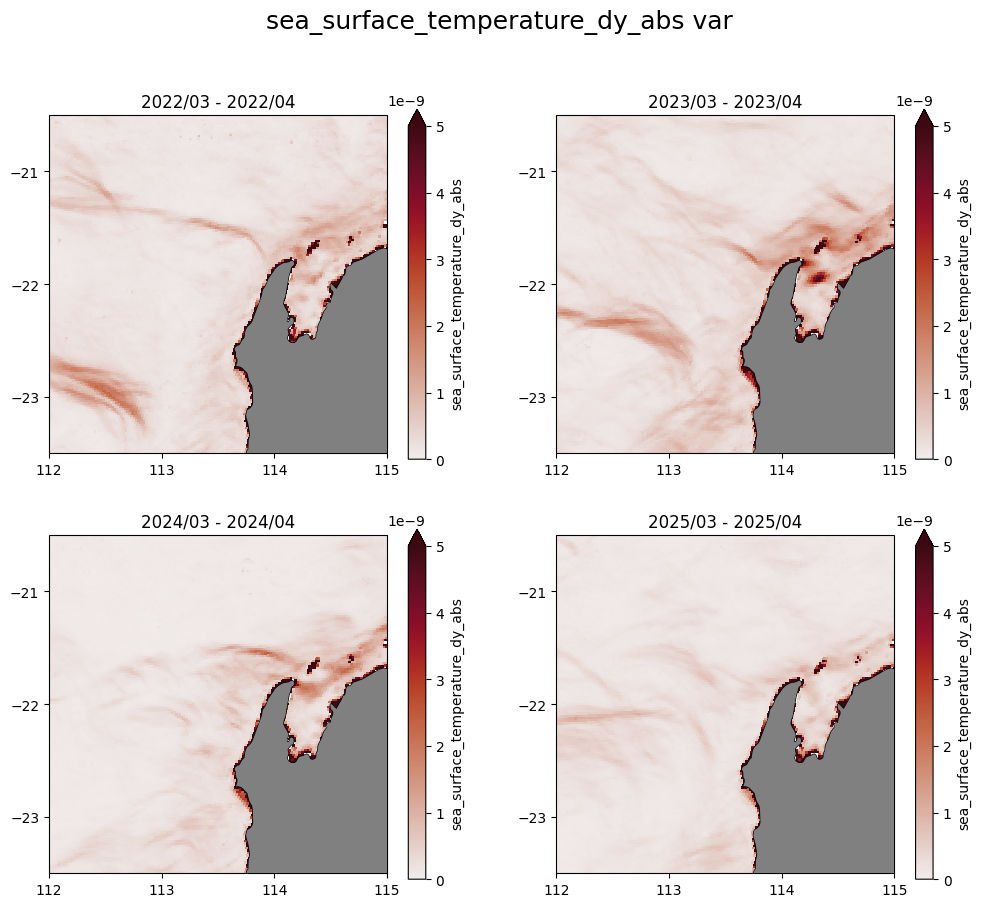

In [42]:
var ="sea_surface_temperature_dy_abs"
type = "var"
cmap = cmocean.cm.amp
vmin = 0
vmax = 5e-9
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degr

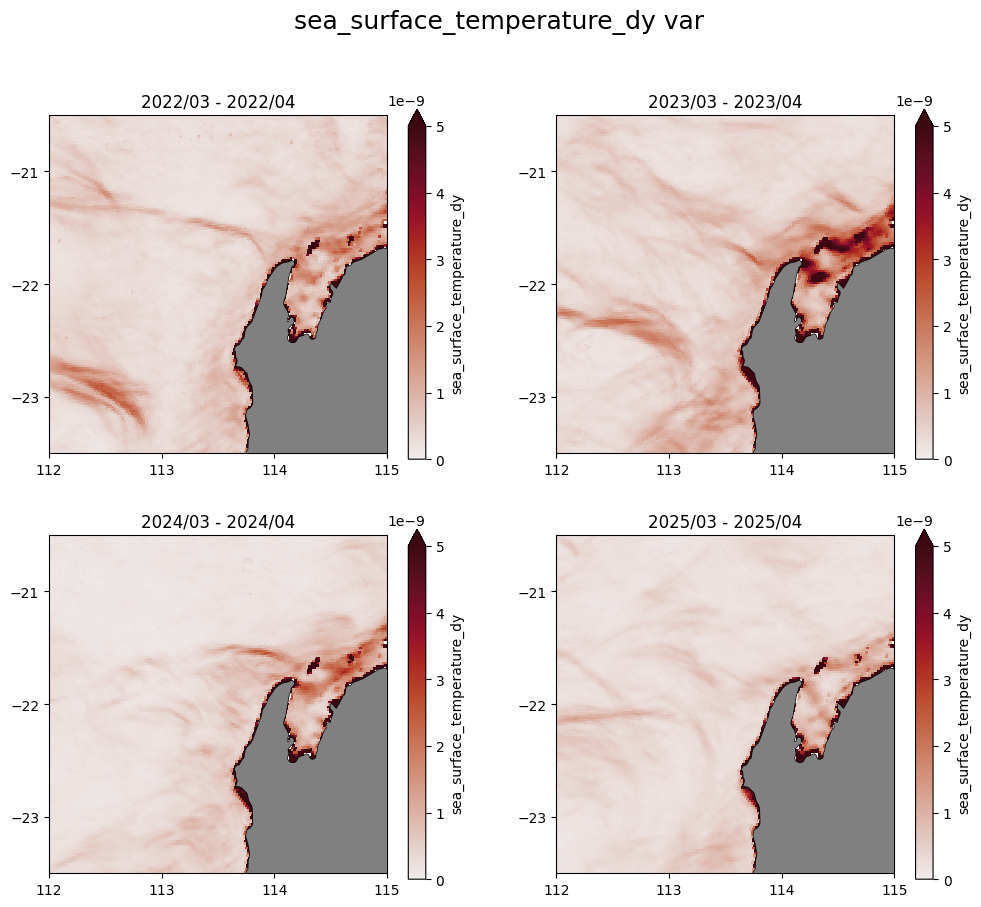

In [43]:
var ="sea_surface_temperature_dy"
type = "var"
cmap = cmocean.cm.amp
vmin = 0
vmax = 5e-9
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degr

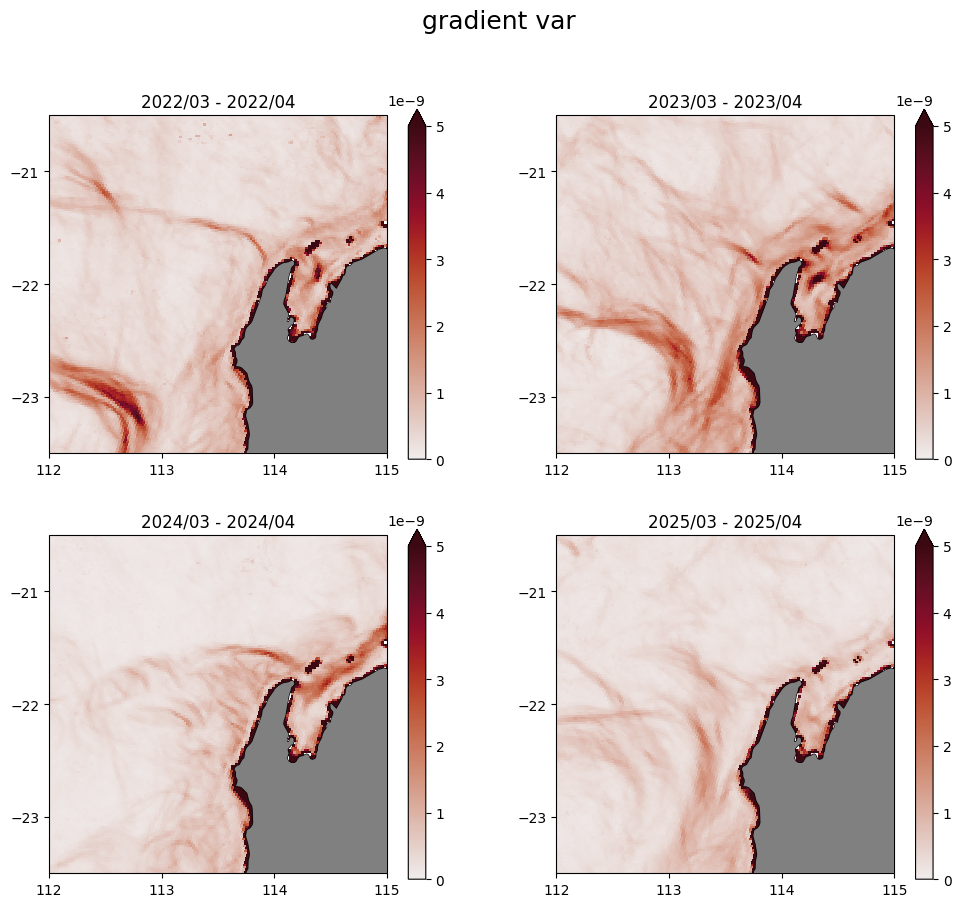

In [44]:
var ="gradient"
type = "var"
cmap = cmocean.cm.amp
vmin = 0
vmax = 5e-9
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

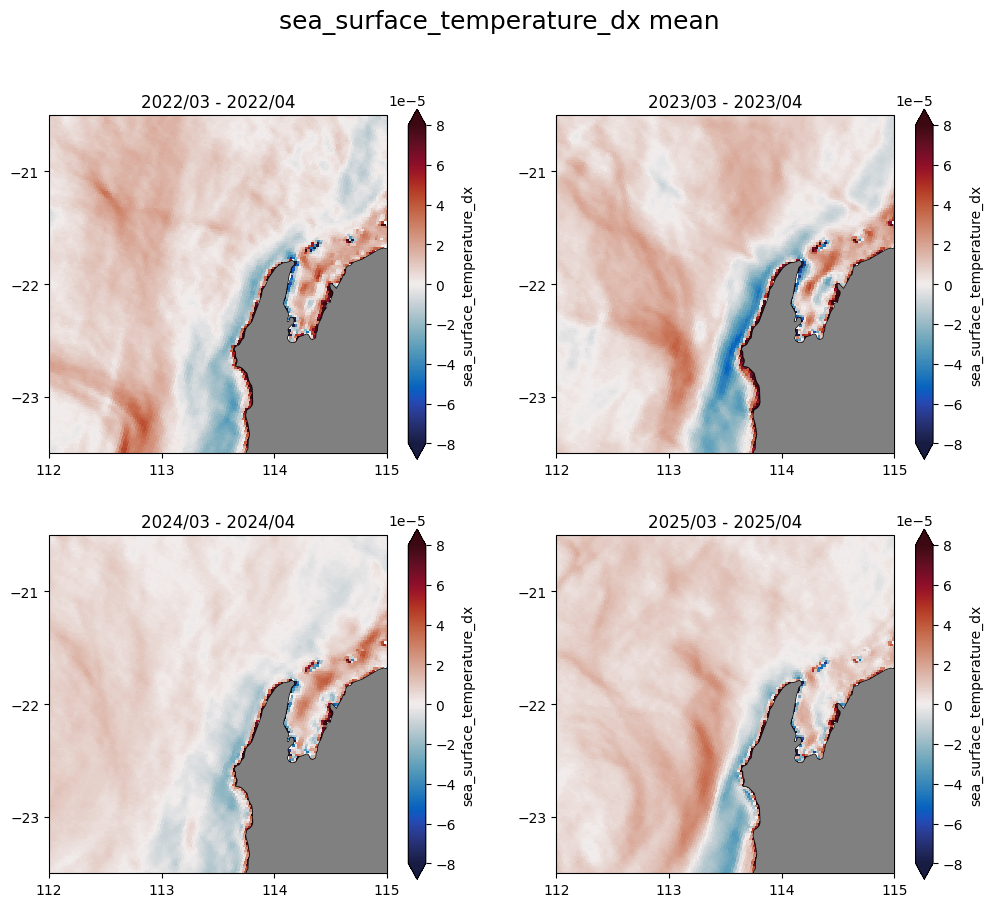

In [45]:
var ="sea_surface_temperature_dx"
type = "mean"
cmap = cmocean.cm.balance
vmin = -8e-5
vmax = 8e-5
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

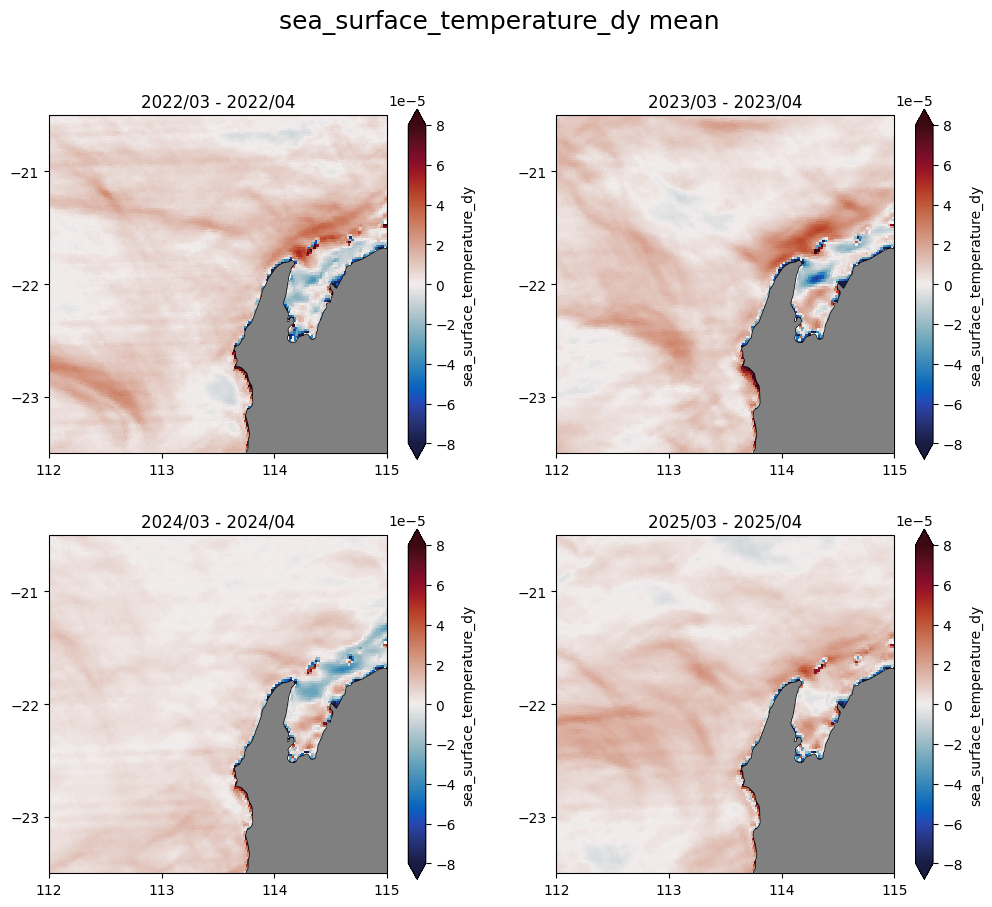

In [46]:
var ="sea_surface_temperature_dy"
type = "mean"
cmap = cmocean.cm.balance
vmin = -8e-5
vmax = 8e-5
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

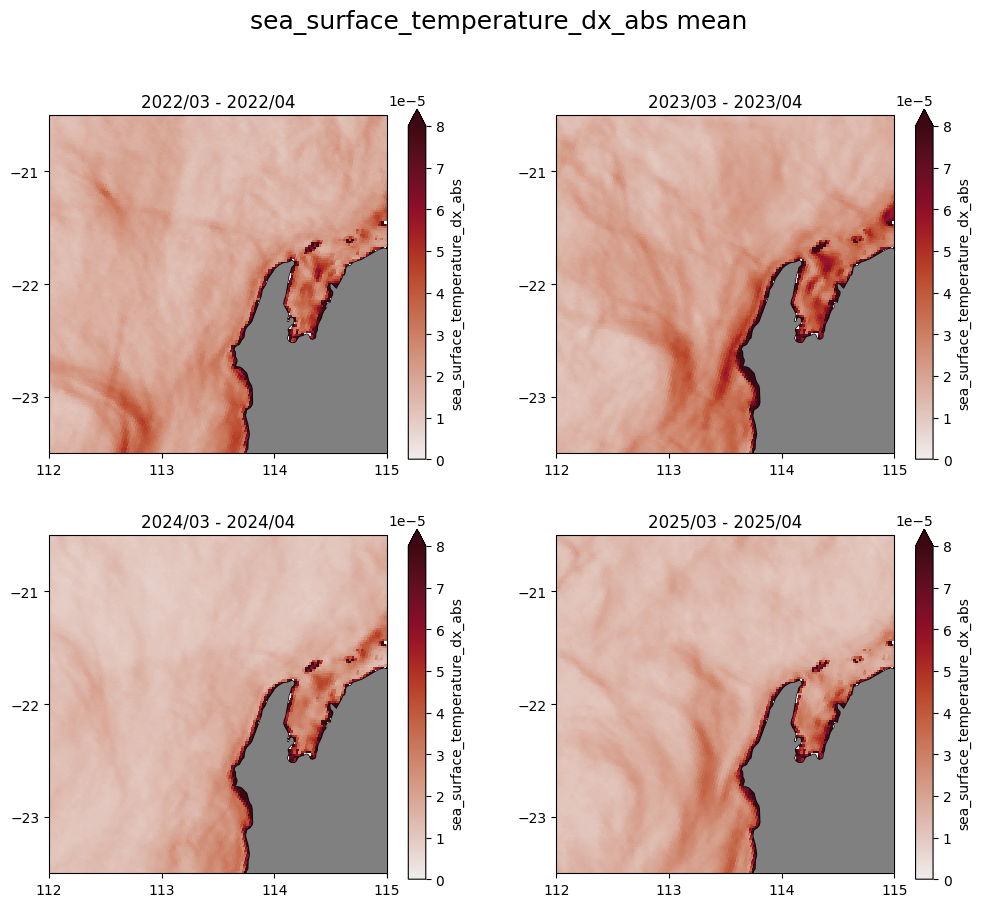

In [47]:
var ="sea_surface_temperature_dx_abs"
type = "mean"
cmap = cmocean.cm.amp
vmin = 0
vmax = 8e-5
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

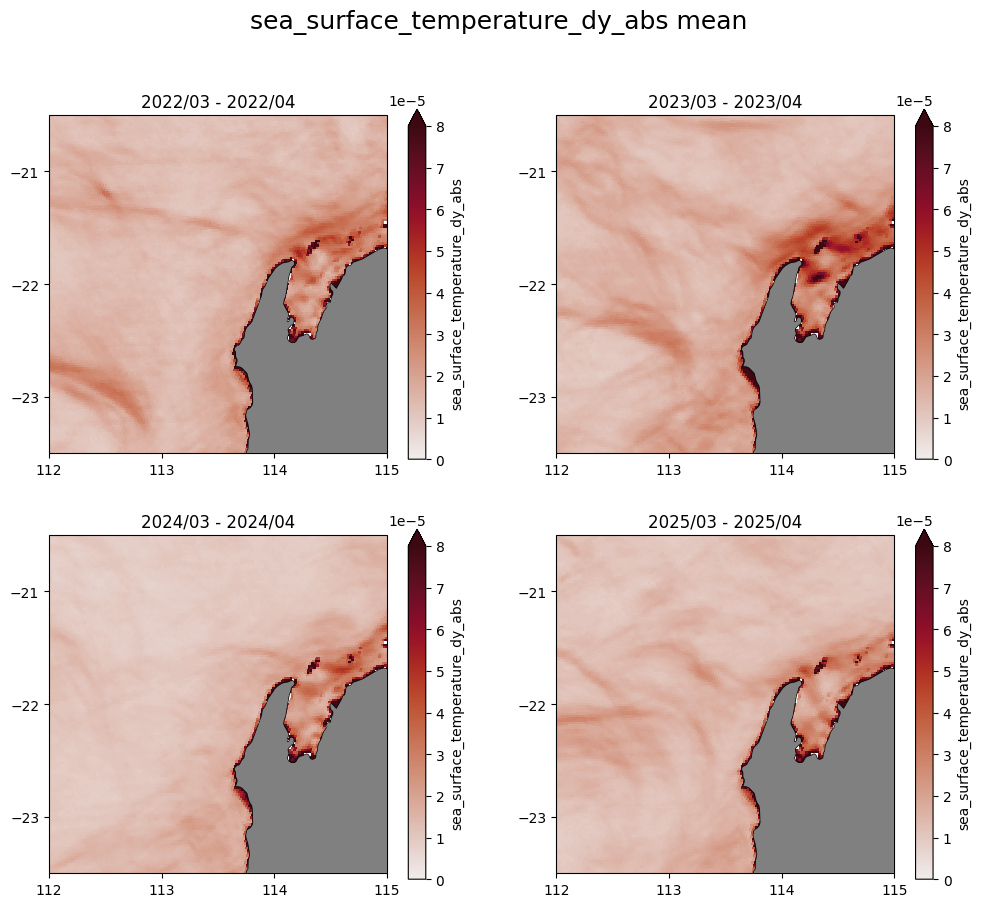

In [48]:
var ="sea_surface_temperature_dy_abs"
type = "mean"
cmap = cmocean.cm.amp
vmin = 0
vmax = 8e-5
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

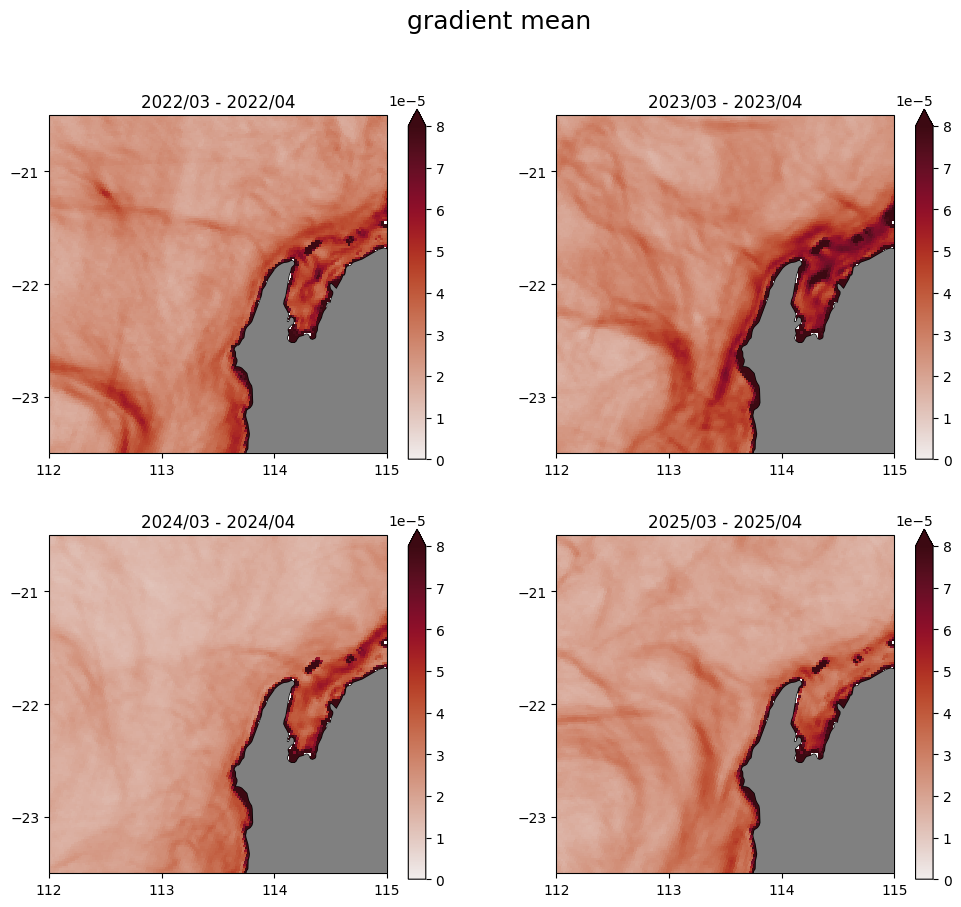

In [49]:
var ="gradient"
type = "mean"
cmap = cmocean.cm.amp
vmin = 0
vmax = 8e-5
fig,axs = plot_multi_properties(ds_list, var, type, cmap, lonlims, latlims, vmin, vmax)
if save_fig:
    fig.savefig(f"figures/{var}_{type}.png", bbox_inches='tight')
if to_tif:
    save_tiff_properties(ds_list, var, type)

In [25]:
# ds = xr.open_dataset('data/H09-AHI-L3C-ACSPO-v2.90_CROP_lon_111_116_lat_-24.5_-19.5_time_2025-03-01T00_00_00_2025-05-01T00_00_00/merge_all.nc')
ds = xr.open_dataset('data/AHI_H08-STAR-L3C-v2.70_CROP_lon_111_116_lat_-24.5_-19.5_time_2022-03-01T00_00_00_2022-05-01T00_00_00/merge_all.nc')

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


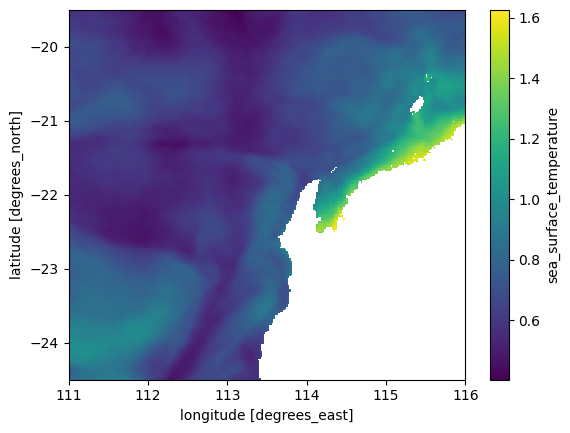

In [26]:
ds["sea_surface_temperature"].std(dim="time").plot(x='lon',y='lat')

In [27]:
# adjust colorbarlims
plim=.000000005
abs(ds['sea_surface_temperature_dx']).var(dim='time').plot(cmap=cmocean.cm.amp, vmin=0, vmax=plim)

KeyError: "No variable named 'sea_surface_temperature_dx'. Did you mean one of ('sea_surface_temperature',)?"

/home/rickdekreij/projects/pysatdownload/.venv/lib/python3.10/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


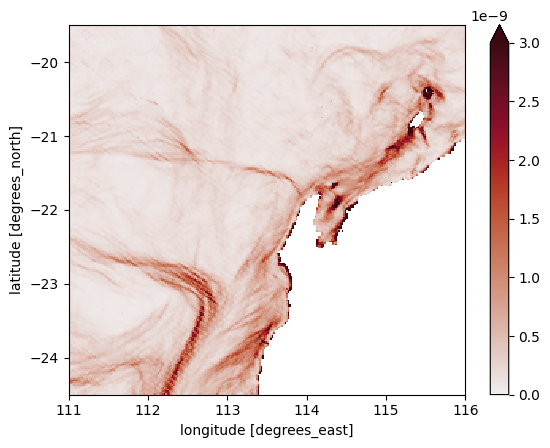

In [ ]:
# adjust colorbarlims
plim=.000000003
# np.sqrt(ds['sea_surface_temperature_dx']**2+ds['sea_surface_temperature_dy']**2).var(dim='time').sel(lon=slice(113,115),lat=slice(-21,-23)).plot(cmap=cmocean.cm.amp, vmin=0, vmax=plim)
np.sqrt(ds['sea_surface_temperature_dx']**2+ds['sea_surface_temperature_dy']**2).var(dim='time').plot(cmap=cmocean.cm.amp, vmin=0, vmax=plim)

In [ ]:
# adjust colorbarlims
plim=.0001
np.sqrt(ds['sea_surface_temperature_dx']**2+ds['sea_surface_temperature_dy']**2).mean(dim='time').sel(lon=slice(113,115),lat=slice(-21,-23)).plot(cmap=cmocean.cm.amp, vmin=0, vmax=plim)

KeyError: "no index found for coordinate 'lon'"

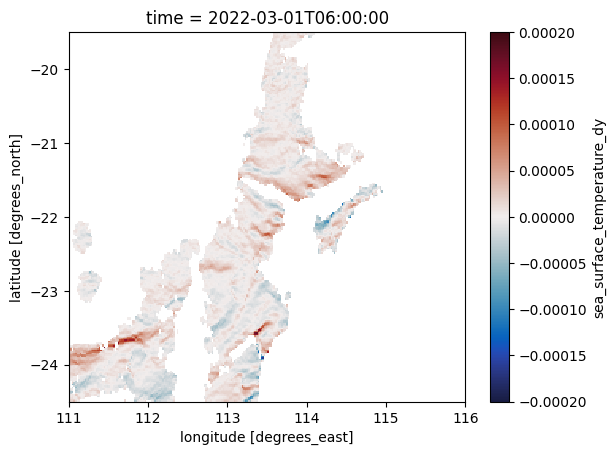

In [ ]:
# adjust colorbarlims
plim=.0002
ds.isel(time=4)['sea_surface_temperature_dy'].plot(cmap=cmocean.cm.balance, vmin=-plim, vmax=plim)

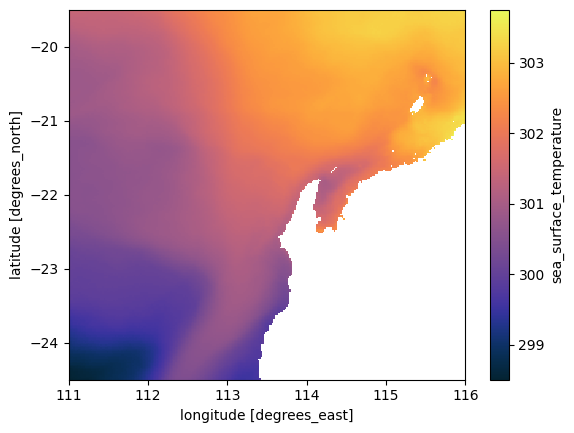

In [ ]:
ds['sea_surface_temperature'].mean(dim='time').plot(cmap=cmocean.cm.thermal)

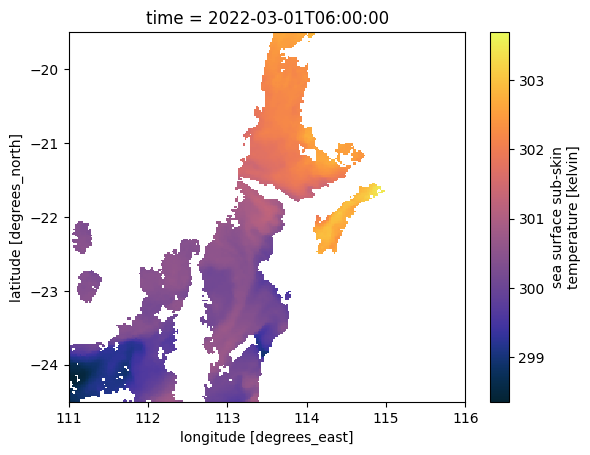

In [ ]:
ds.isel(time=4)['sea_surface_temperature'].plot(cmap=cmocean.cm.thermal)

In [ ]:
dsh8 = xr.open_dataset('data/AHI_H08-STAR-L2P-v2.70_CROP_lon_111_116_lat_-24.5_-19.5_time_2022-03-01T00_00_00_2022-05-01T00_00_00/temp/20220409180000-STAR-L2P_GHRSST-SSTsubskin-AHI_H08-ACSPO_V2.70-v02.0-fv01.0.nc')

OSError: [Errno -101] NetCDF: HDF error: '/home/rickdekreij/projects/pysatdownload/data/AHI_H08-STAR-L2P-v2.70_CROP_lon_111_116_lat_-24.5_-19.5_time_2022-03-01T00_00_00_2022-05-01T00_00_00/temp/20220409180000-STAR-L2P_GHRSST-SSTsubskin-AHI_H08-ACSPO_V2.70-v02.0-fv01.0.nc'

: 